Import necessary packages: Numpy, Pandas, matplotlib

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

Mount your google drive (if you have a google account) or upload files (go on the file icon on the left -> right click). Copy path of zip.train and zip.test and load them as numpy arrays using the following code (insert the path as string).

In [2]:
#path_to_train = '/content/drive/My Drive/ML_Class_2020/KNN/zip.train'
#path_to_test = '/content/drive/My Drive/ML_Class_2020/KNN/zip.test'
path_to_train = 'zip.train'
path_to_test = 'zip.test'
training_data = np.array(pd.read_csv(path_to_train, sep=' ', header=None))
test_data = np.array(pd.read_csv(path_to_test, sep =' ',header=None))

X_train, y_train = training_data[:,1:-1], training_data[:,0]
X_test, y_test = test_data[:,1:], test_data[:,0]

# We only want to classify two different digits. Note the only difference is
# that we don't load as many ones as we load zeros.

X_train_0 = X_train[y_train == 0]
X_train_1 = X_train[y_train == 1][:30]
X_train = np.vstack((X_train_0, X_train_1))

y_train_0 = y_train[y_train == 0]
y_train_1 = y_train[y_train == 1][:30]
y_train = np.hstack((y_train_0, y_train_1))

X_test_0 = X_test[y_test == 0]
X_test_1 = X_test[y_test == 1][:12]
X_test = np.vstack((X_test_0, X_test_1))

y_test_0 = y_test[y_test == 0]
y_test_1 = y_test[y_test == 1][:12]
y_test = np.hstack((y_test_0, y_test_1))
print(y_test.shape)

(371,)


In [3]:
def show_numbers(X):
    num_samples = 90
    indices = np.random.choice(range(len(X)), num_samples)
    print(indices.shape)
    sample_digits = X[indices]

    fig = plt.figure(figsize=(20, 6))

    for i in range(num_samples):
        ax = plt.subplot(6, 15, i + 1)
        img = 1-sample_digits[i].reshape((16, 16)) 
        plt.imshow(img, cmap='gray')
        plt.axis('off')


(90,)


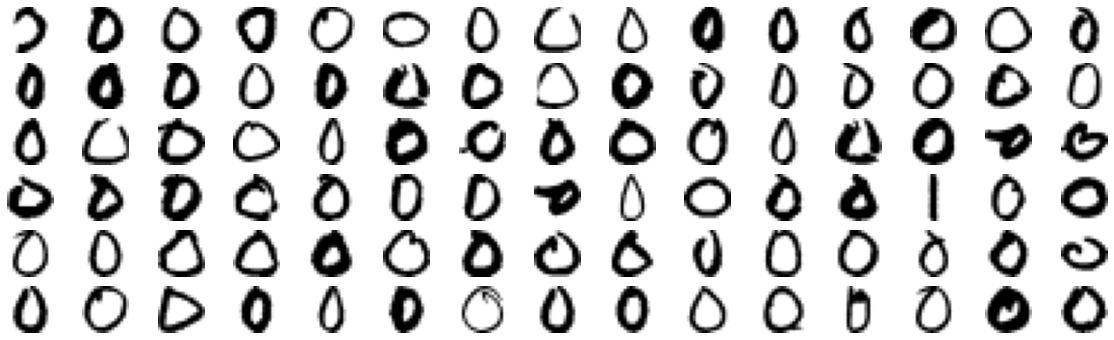

In [4]:
show_numbers(X_test)

Choose one of the classifiers you implemented and use it on the following task: Take a look at the provided notebook. It loads the ZIP-Code’s zeros and ones, but now there are manymore zeros than there are ones. We are going to believe that these digits represent geneticdata. Actually, we are virologists trying to develop a test to determine which of the data belongs to infected patients (the ones) and which do not (the zeros). Train/apply your model on the data and do the tasks of the exercise.

In [5]:
class KNearestNeighbors:
    '''
    Think about defining more functions that will help you building this algorithm.
    Optimally, one that takes in k and a test image as a parameter.
    '''
    def squared_euclidean_distance(self, x_1, x_2):
      '''
      np.sum(x, axis = 1) will be summing all elements over the pixel dimension (axis = 1)
      '''
      return np.sum((x_1-x_2)**2, axis = 1)

    def __init__(self, k): 
        self.k = k
    
    def get_neighbourhood(self, X_train, X_test_set):
        return self.squared_euclidean_distance(X_train, X_test_set)
    
    def get_k_smallest_distances(self, distances):
        enumerated = list(enumerate(distances))
        index_sorted = sorted(enumerated, key=lambda x:x[1])
        return [index_sorted[i][0] for i in range(self.k)]
    
    def get_average_voted_y_label(self, Y_train, k_smallest_pos):
        selected_labels = np.array([int(Y_train[i]) for i in k_smallest_pos])
        return np.argmax(np.bincount(selected_labels))
                
    def classify_single(self, X_train, Y_train, X_test_set):
        distances = self.get_neighbourhood(X_train, X_test_set)
        k_smallest_pos = self.get_k_smallest_distances(distances)
        return self.get_average_voted_y_label(Y_train, k_smallest_pos)
        
    def classify_loop(self, X_train, Y_train, X_test):
        return [self.classify_single(X_train, Y_train, X_test_set) for X_test_set in X_test] 
    
def calculate_accuracy(true_y, pred_y, classes):
    class_sum = 0
    for class_num in classes:
        val_sum = 0
        for true_val, pred_val in zip(true_y, pred_y): 
            if class_num == true_val:
                if true_val == pred_val:
                    val_sum += 1
        class_sum += val_sum
    return class_sum / len(true_y)

In [34]:
# Task 1: split the training set into training and validation set -> 80:20 split
#         use KNN for classification of train set
#         do this 5-times -> cross-validation
#import random

def cross_validation(X_train, y_train, Ks, nr_folds = 5):
    all_accuracies = []
    #shoudn't the random shuffle only happen only once, then loop through the shuffled folds
    indices = np.arange(len(X_train))
    np.random.shuffle(indices)
    fold_indices_list = np.array_split(indices, nr_folds)
    for fold_counter, val_indices in enumerate(fold_indices_list):
#         same as above, only shuffle once
#         choices = list(range(len(X_train)))
#         random.shuffle(choices) 
#         val_indeces = [x for x in choices if x not in train_indeces]

        X_val = X_train[val_indices]
        y_val = y_train[val_indices]
        X_training = np.delete(X_train, val_indices, 0)
        y_training = np.delete(y_train, val_indices, 0)

        accuracy_list = []
        for k in Ks:
            kNN = KNearestNeighbors(k)
            y_pred = kNN.classify_loop(X_training, y_training, X_val)
            accuracy_list += [calculate_accuracy(y_val, y_pred, list(range(2)))]
        all_accuracies += [accuracy_list]
    return(np.array(all_accuracies))

In [39]:
Ks = range(2,21)
acc = cross_validation(X_train, y_train, Ks)

In [40]:
acc_T = acc.T
acc_T

array([[1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.]])

In [41]:
# mean, accuracy per k:
# for row in acc_T:
#     print(np.mean(row))
np.mean(acc_T, axis=1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1.])

In [42]:
import statistics
for row in acc_T:
    print(statistics.variance(row))

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
